In [1]:
%load_ext autoreload
%autoreload 2

import time

import numpy as np

from scipy import spatial
from sklearn.preprocessing import scale

from gtda.homology import VietorisRipsPersistence

from steenroder import *
import gudhi

from matplotlib import pyplot as plt

In [2]:
def get_density_filtered_point_cloud(weight_array,
                                     k_th_nearest=200,
                                     percentage=0.3,
                                     user_axis=1):
    """
    Returns a density filtered point cloud of 9-vectors
    Parameters
    ----------
    weight_array: array
        An array of 9-dimensional points i.e the weights of 3x3 patches
    k_th_nearest : integer, optional, default: 200
        Indicates the k-th neighbour used as a density estimator
    percentage : integer, optional, default: 0.3
        The percentage of the point cloud cardinality to be left after filtration
    user_axis :
        integer 0 or 1 for scaling axis, 0 is column normalization, 1 is row norm.
    """
    normalized_weight_array = scale(weight_array, axis=user_axis)
    m_dimension, n_dimension = normalized_weight_array.shape
    number_of_kth_densest_points = int(percentage*m_dimension)
    condensed_weight_distance_matrix = spatial.distance.pdist(normalized_weight_array)
    redundant_weight_distance_matrix = spatial.distance.squareform(condensed_weight_distance_matrix)
    kth_nearest_index_matrix = np.argsort(redundant_weight_distance_matrix, axis=1)
    kth_nearest_index_vector = np.zeros((m_dimension, 1), dtype=int)
    for i in range(m_dimension):
        kth_nearest_index = kth_nearest_index_matrix[i][k_th_nearest]
        kth_nearest_index_vector[i] = kth_nearest_index
    # kth_nearest_distances = redundant_weight_distance_matrix[kth_nearest_index_vector]
    kth_nearest_distances = np.take_along_axis(redundant_weight_distance_matrix,
                                               kth_nearest_index_vector, axis=1)
    kth_nearest_indices_sorted = np.argsort(kth_nearest_distances, axis=0)
    p_of_kth_nearest_indices = kth_nearest_indices_sorted[0:number_of_kth_densest_points]
    pth_densest_points = normalized_weight_array[p_of_kth_nearest_indices]
    pth_densest_points = np.reshape(pth_densest_points, (-1, n_dimension))

    return pth_densest_points

In [37]:
weights = np.load('../data/vgg16_lay2.npy')

/Users/panda/opt/anaconda3/envs/gtda-ulupo-py38/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.

/Users/panda/opt/anaconda3/envs/gtda-ulupo-py38/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning:

Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 



1228


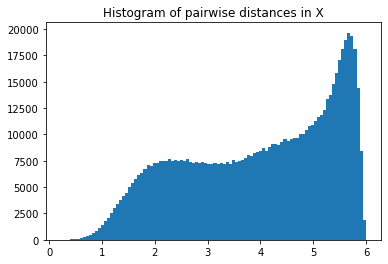

In [41]:
X = get_density_filtered_point_cloud(weights, k_th_nearest=15, percentage=0.3, user_axis=1)
print(len(X))

dm = spatial.distance.pdist(X)
plt.hist(dm, bins=100);
plt.title("Histogram of pairwise distances in X");
plt.show()

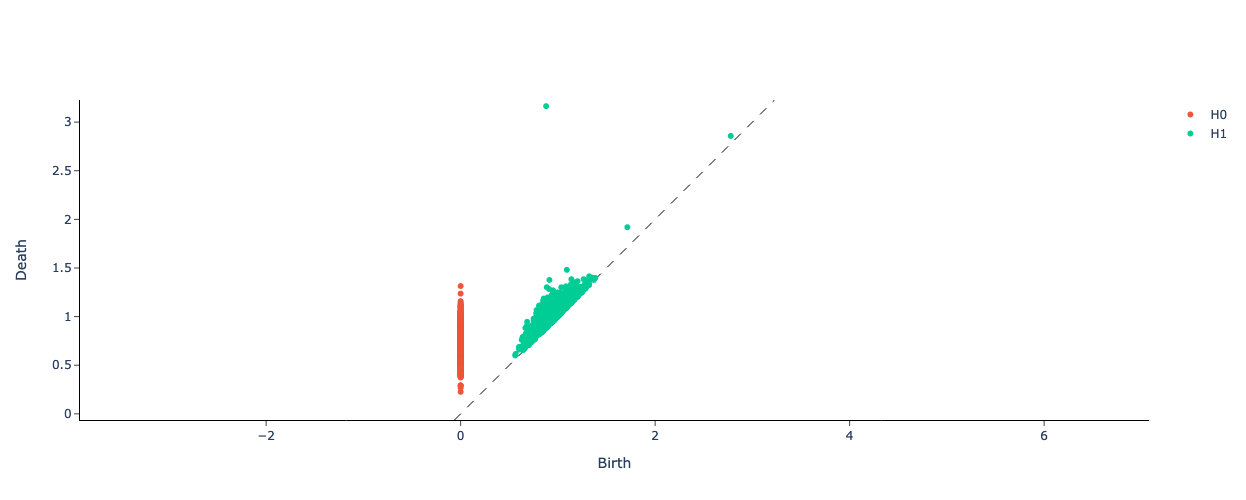

In [42]:
max_edge_length = 5

VietorisRipsPersistence(homology_dimensions=(0, 1),
#                         collapse_edges=True,
                        max_edge_length=max_edge_length,
                        infinity_values=np.inf).fit_transform_plot([X]);

In [44]:
simplex_tree_coll = gudhi.RipsComplex(points=X, max_edge_length=max_edge_length).\
    create_simplex_tree(max_dimension=1)  # Only get the 1-skeleton this time

In [110]:
simplex_tree_coll.collapse_edges(nb_iterations=1)

filtration = []
for s in simplex_tree_coll.get_filtration():
    filtration.append(tuple(s[0]))

print(f"Filtration with {len(filtration)} simplices")

Filtration with 38855 simplices


In [111]:
simplex_tree_coll.expansion(2)  # Get the three-simplices after collapse

filtration = []
filtration_values = []
for s in simplex_tree_coll.get_filtration():
    filtration.append(tuple(s[0]))
    filtration_values.append(s[1])

filtration_values = np.asarray(filtration_values, dtype=np.float64)

print(f"Filtration with {len(filtration)} simplices")

Filtration with 737306 simplices


In [112]:
barcode, st_barcode = barcodes(
    1,
    filtration, 
    homology=True,
    filtration_values=filtration_values,
    return_filtration_values=True,
    maxdim=2
)

Usual barcode computed, time taken: 7.19675612449646


/Users/panda/opt/anaconda3/envs/gtda-ulupo-py38/lib/python3.8/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning:


Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'cochain' of function '_populate_st_mat'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../steenroder/__init__.py", line 262:
@njit
def _populate_st_mat(st_mat, cochain, idxs, spx2idx_dim):
^




Steenrod matrix computed, time taken: 455.55756187438965
Steenrod barcode computed, time taken: 249.04775595664978


In [123]:
gudhi_barcode = simplex_tree_coll.persistence(homology_coeff_field=2, persistence_dim_max=True)
check_agreement_with_gudhi(gudhi_barcode, barcode)